<a href="https://colab.research.google.com/github/quynhu-d/hse_risk_management_1/blob/main/notebooks/RM_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект

## Библиотеки

In [1]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

from tqdm.auto import tqdm, trange
from copy import copy, deepcopy

import sys
import warnings
warnings.simplefilter("ignore")


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# folder = '/content/drive/MyDrive/RM_project/'
folder = './'

In [4]:
random_seed = 42
np.random.RandomState(seed=random_seed)

RandomState(MT19937) at 0x1C90EF65940

## Загрузка данных

In [5]:
data = pd.read_excel(folder+'Final_data.xlsx')

In [6]:
print(data.shape, '\n')

print(data.columns, '\n')

(2922, 32) 

Index(['Date', 'Курс доллара', 'Курс евро', 'Нефть', 'МосБиржа', 'РТС',
       'Золото', 'Серебро', 'Платина', 'КБД 0.25', 'КБД 0.5', 'КБД 1', 'КБД 5',
       'КБД 10', 'КБД 15', 'КБД 20', 'КБД 30', 'ОФЗ_26207', 'ОФЗ_26215',
       'ОФЗ_26218', 'ОФЗ_26219', 'ОФЗ_26222', 'Аэрофлот', 'Газпром',
       'ГМК Норникель', 'Лукойл', 'МТС', 'ПИК', 'Роснефть', 'Сбербанк',
       'Татнефть', 'Яндекс'],
      dtype='object') 



In [7]:
# Заполнение пропусков
data.fillna(method='bfill', inplace=True)
data.fillna(method='ffill', inplace=True)

### Разбиение данных

In [8]:
def split_data(df, split_date, start_date=None, end_date=None):
    train = df[df.Date <= split_date]
    test = df[df.Date > split_date]
    if start_date is not None:
        train = train[train.Date >= start_date]
    if end_date is not None:
        test = test[test.Date <= end_date]
    return train, test

In [9]:
#разбиваем данные на train и test по дате

df_train, df_test = split_data(data, split_date='2022-06-09')
print(df_train.shape[0], df_test.shape[0])

2717 205


## Часть 3: Стохастические модели динамики

In [10]:
from stoch_models import *

### Винеровский процесс

$(W_{t})_{t \in T}$ - Винеровский процесс.

Алгоритм генерации (дискретизированной) траектории процесса в заданные моменты времени $t_{1}, .., t_{n}$:
1. задать стартовое значение $w_{0}$
2. сгенерировать дискретизированную траекторию процесса гауссовского белого шума $N(0,1): \xi_{1}, ..., \xi_{n}$
3. $\forall j = 1, .., n : w_{t_{j}} = w_{t_{j-1}} + \sqrt{t_{j} - t_{j-1}} \ \xi_{j}$

Набор $w_{0}, w_{t_{1}} , .., w_{t_{n}}$ – это дискретизированная траектория Винеровского процесса. Требует $O(n)$ операций.

In [17]:
N_traj = 15
w0 = 0
t0 = 0
N = data.shape[0]
t_step = 1
t_array = np.round(np.arange(t0, N, t_step))
dt = np.diff(t_array)

wiener_traj = Wiener_process(w0, dt, N_traj)

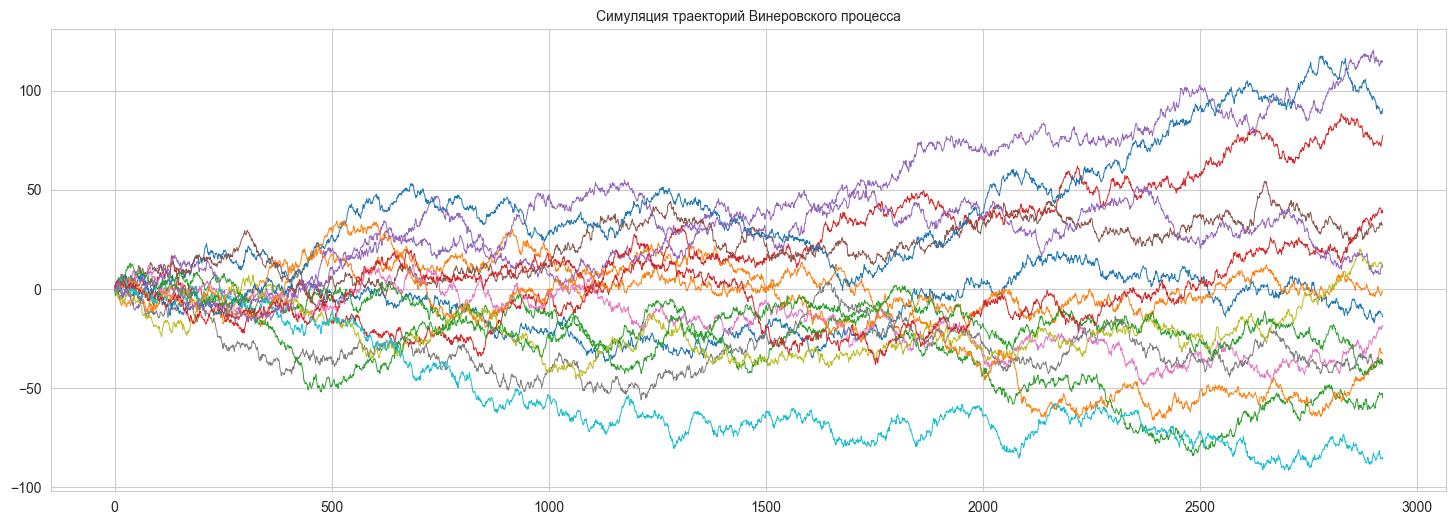

In [18]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(t_array, wiener_traj.T, linewidth=0.7)
ax.set_title('Симуляция траекторий Винеровского процесса', fontsize=10)
plt.show()

### Скоррелированные процессы

Cкоррелированность риск-факторов, определяется скоррелированностью приращений Винеровского процесса.

[Разложение Холецкого](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B7%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A5%D0%BE%D0%BB%D0%B5%D1%86%D0%BA%D0%BE%D0%B3%D0%BE#%D0%9F%D1%80%D0%B8%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F) применяется для генерации коррелированных случайных величин.

Пусть $X$ — вектор из независимых стандартных нормальных случайных величин, а $\Sigma =LL^{T}$ — желаемая ковариационная матрица.

Тогда вектор $ Y=L \cdot X $ будет иметь многомерное нормальное распределение с нулевым математическим ожиданием и ковариационной матрицей $\Sigma$.

См. `generate_dW_corr`.

### $1. \ dX_{t} = a \ dt + b \ dW_{t}$

$d X_t = a \ dt + b \ dW_t$\
$\Delta X_t = a \Delta t + b \Delta W_t$\
$X_t = X_{t-1} + a \Delta t + b \Delta W_t$

Если сделать следующие замены: $y=\Delta X_{t}, \ x = \Delta t$, то получим  $y = ax + b \varepsilon_t$ и найдем коэффициенты из линейной регрессии.

См. `parametrs_estimation_1`, `process_1`.

### $ 2. \ dX_{t} = a \ X_{t} \ dt + b \ X_{t} \ dW_{t}$

$d X_t = a \ X_t \ dt + b \ X_t \ dW_t$

$\Delta X_{t} = a \ X_t \Delta t + b \ X_t \Delta W_t$

$\frac{\Delta X_{t}}{X_t} = a \Delta t + b \Delta W_t$

$X_t = X_{t-1} + a X_{t-1} \Delta t + b X_{t-1} \Delta W_t$

Сделаем следующие замены: $y=\frac{\Delta X_{t}}{X_t}, \ x = \Delta t$.\
Получим  $y = ax + b \varepsilon_t$. Найдем коэффициенты из линейной регрессии.

См. `parametrs_estimation_2`, `process_2`.

### $3. \ CIR: \ d X_{t} = a (b-X_{t})dt + c\sqrt{X_{t}} d W_{t} $


Стохастическое дифференциальное уравнение для процесса Кокса-Ингерсолла-Росса выглядит следующим образом:

$ d r_{t} = a (b-r_{t})dt + c\sqrt{r_{t}} d W_{t} $

Для моделирования процесса воспользуемся дискретным уравнением:

$ r_{t} = r_{t-1} + a (b-r_{t-1}) \Delta t + c\sqrt{|{r_{t-1}}|} \Delta W_{t} $

Используется для симмуляции процентных ставок.

Подбор параметров осуществляется следующим образом.

$ \Delta r_{t} = a (b-r_t) \Delta t + c\sqrt{r_{t}} \Delta W_{t} $

$ \frac{\Delta r_{t}}{\sqrt{r_{t}}} = ab \frac{\Delta t}{{\sqrt{r_{t}}}} - a \frac{r_{t} \Delta t}{{\sqrt{r_{t}}}}  + c \Delta W_{t}$

$ \frac{\Delta r_{t}}{\sqrt{r_{t}}} = ab \frac{\Delta t}{{\sqrt{r_{t}}}} - a \sqrt{r_{t}} \Delta t  + c \Delta W_{t}$

Можно сделать следующие замены:

$y = \frac{\Delta r_{t}}{\sqrt{r_{t}}}$

$x_1 = \frac{\Delta t}{{\sqrt{r_{t}}}}$

$x_2 = \sqrt{r_{t}} \Delta t$

Тогда получим $y = abx_1 - ax_2 + c \varepsilon_t$ и найдем коэффициенты из линейной регрессии.


См. `parametrs_estimation_CIR`, `process_CIR`.

### $4. \ FX$

В общем виде модель выглядит следующим образом:

$d(\ln X_t) = \frac{dX_t}{X_t} = k(\theta - \ln X_t)dt + \sigma_{FX}(t)dW_t$

Пусть $Y_t = \ln X_t$.

$dY_t = k(\theta - Y_t)dt + \sigma dW_t$

В дискретном случае:

$Y_t = Y_{t-1} + k(\theta - Y_{t-1})\Delta t + \sigma \Delta W_t$

$X_t = exp \{Y_t\}$

Подбор параметров:\
$\Delta Y_{t} = k(\theta - Y_t)\Delta t + \sigma \Delta W_{t} $

$\Delta Y_{t} = k \theta \Delta t - k Y_t \Delta t + \sigma \Delta W_{t} $

Тогда заменяем $y = \Delta Y_{t}, \ x_1 = \Delta t, \ x_2 = Y_t \Delta t$.

См. `parametrs_estimation_FX`, `process_FX`.

### Примеры

#### Пример 1

In [11]:
f_col = 'Курс доллара'
sm = Stoch_Models(factor_name=f_col,
                  value_train = df_train[f_col].values, value_test = df_test[f_col].values,
                  t_train = list(df_train.index), t_test = list(df_test.index),
                  models=['m1', 'm2', 'm3'], N_traj=25)

rmse 

m1: 22.3923
m2: 19.7056
m3: 10.5558


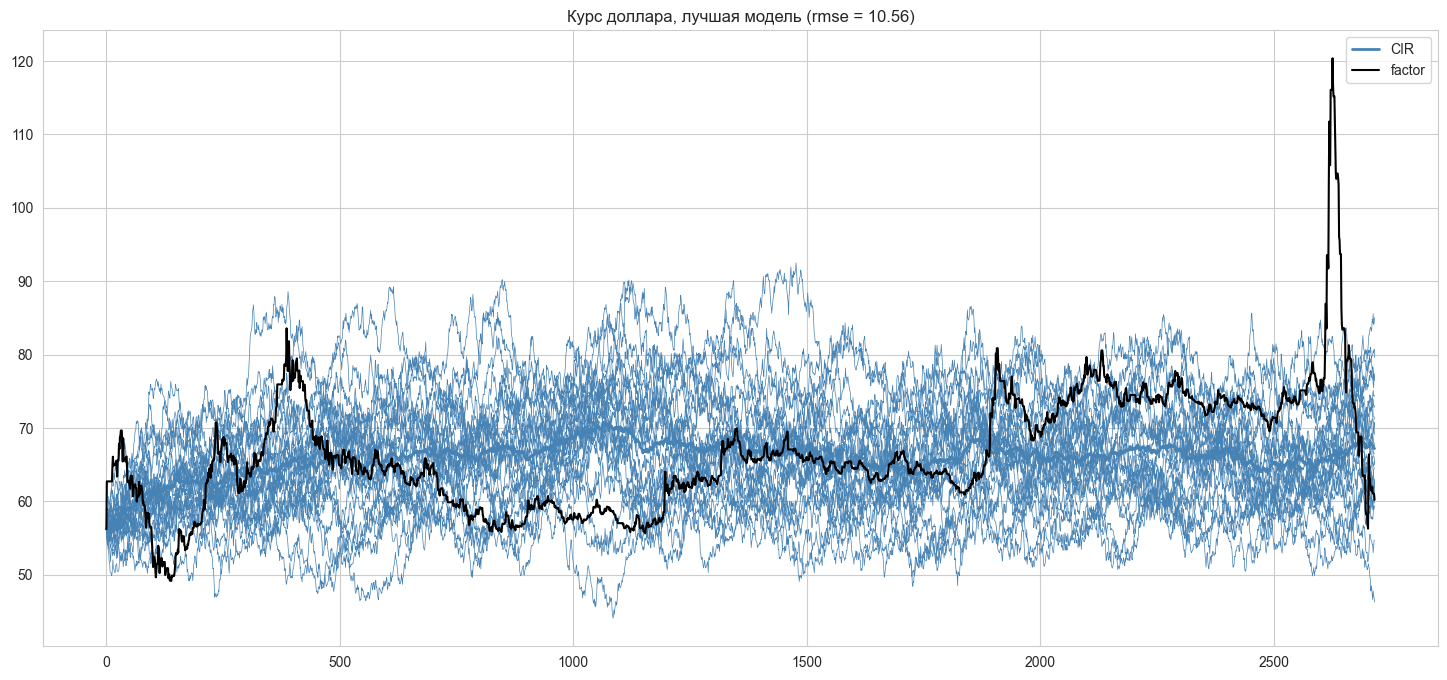

In [12]:
sm.choose_model()

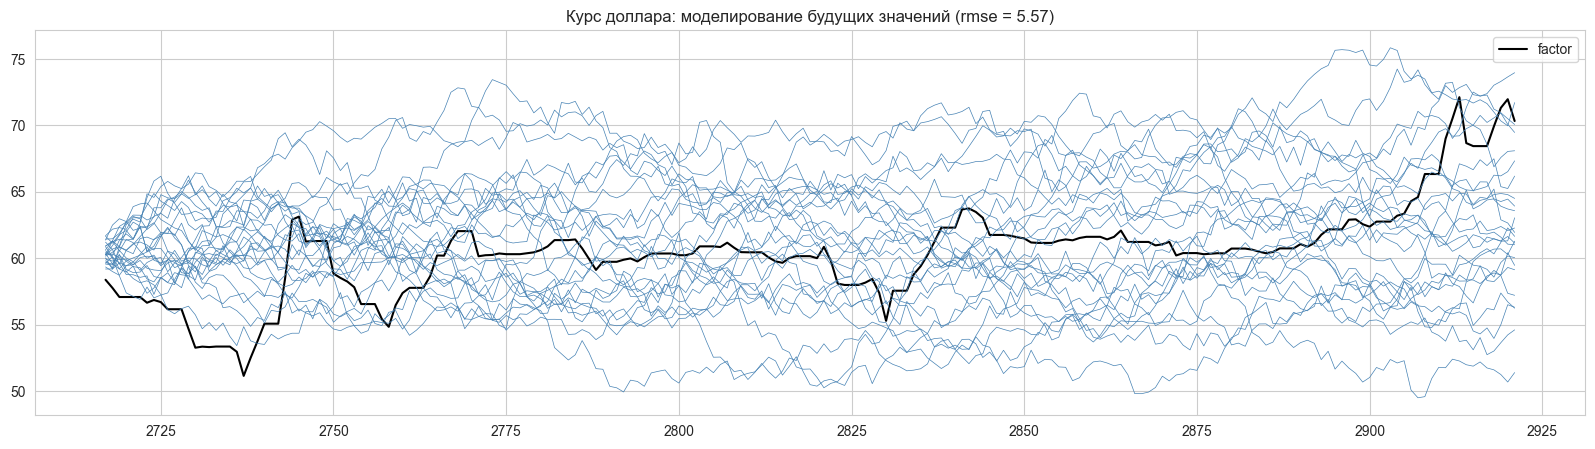

In [13]:
res1_all = sm.future_simulation(plot=1)

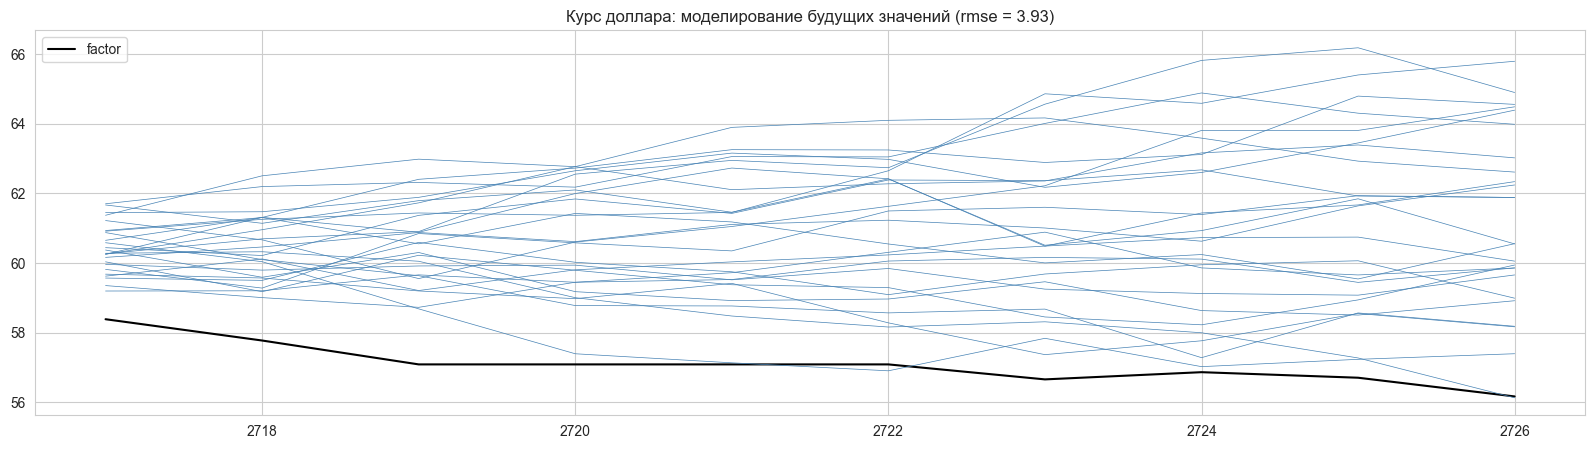

In [14]:
res1_10 = sm.future_simulation(n_steps=10, plot=1)

#### Пример 2

In [15]:
f_col = 'Нефть'
sm = Stoch_Models(factor_name=f_col,
                  value_train = df_train[f_col].values, value_test = df_test[f_col].values,
                  t_train = list(df_train.index), t_test = list(df_test.index),
                  models=['m1', 'm2', 'm3'], N_traj=25)
sm.choose_model()

rmse 

m1: 45.7086
m2: 82.7147
m3: 28.1984


In [16]:
res2_all = sm.future_simulation(plot=1)

#### Пример 3

mape 

m1: 0.9488
m2: 0.5741
m3: 0.3808


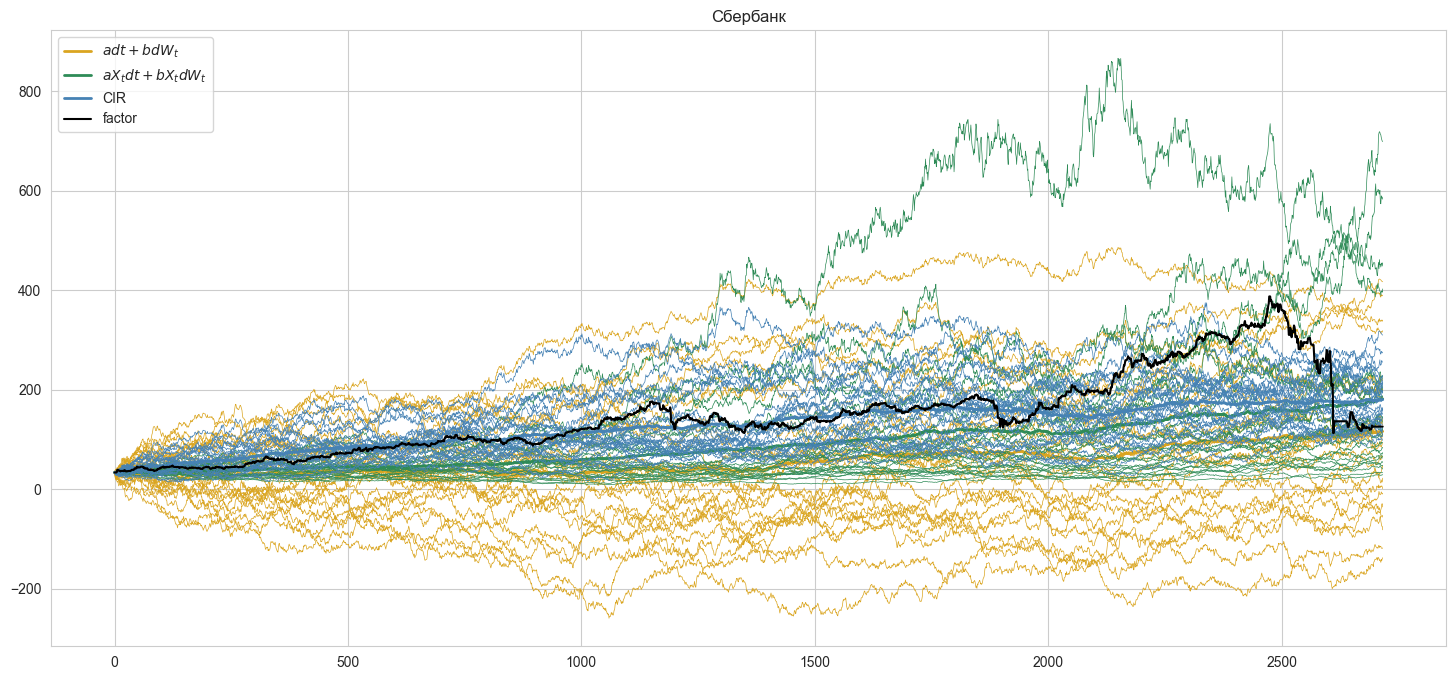

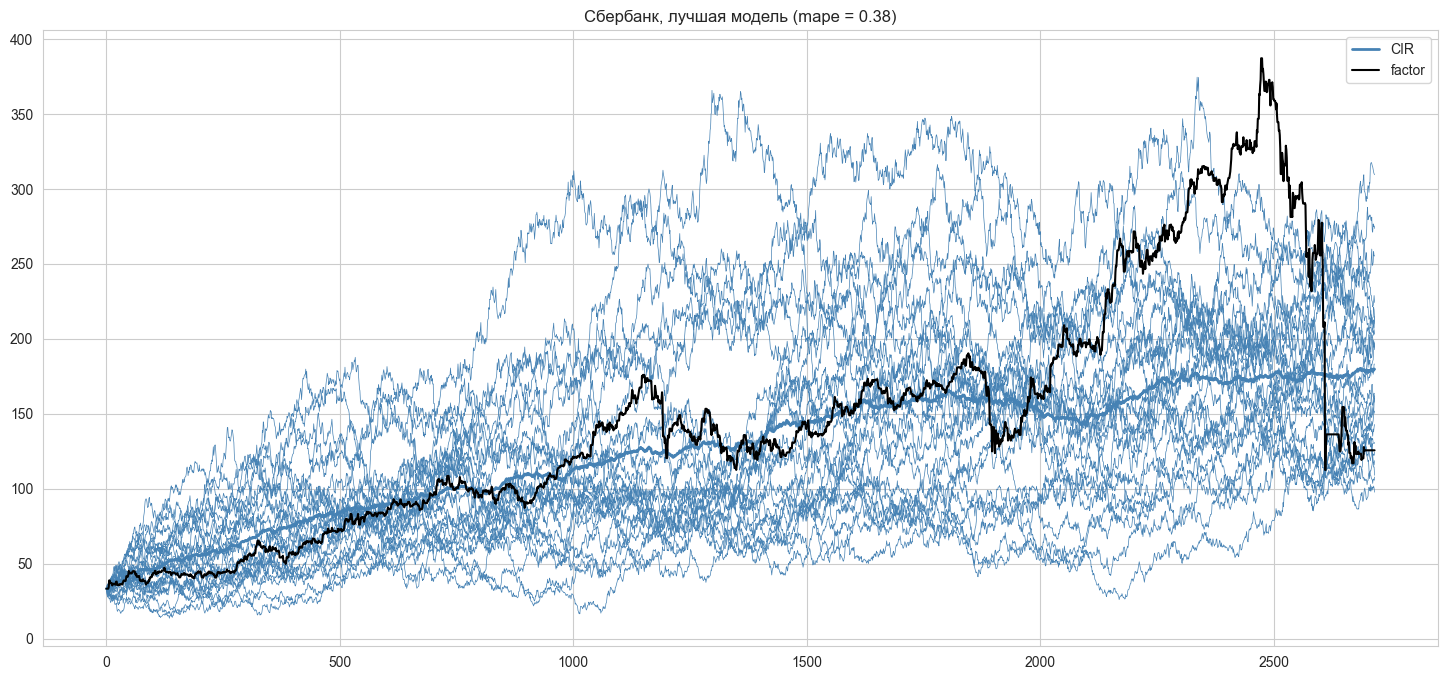

In [17]:
f_col = 'Сбербанк'
sm = Stoch_Models(factor_name=f_col,
                  value_train = df_train[f_col].values, value_test = df_test[f_col].values,
                  t_train = list(df_train.index), t_test = list(df_test.index),
                  models=['m1', 'm2', 'm3'], N_traj=25)
sm.choose_model(metric='mape')

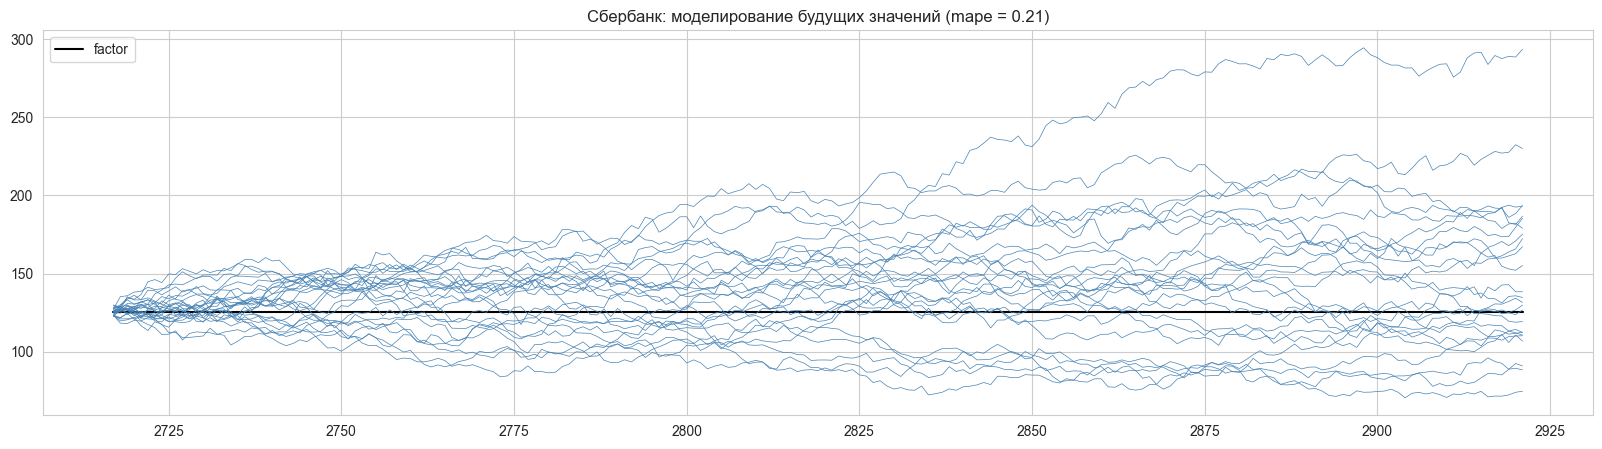

In [18]:
res3_all = sm.future_simulation(plot=1)

### Симуляция риск-факторов


Портфель состоит из инструментов.\
Инструменты:
1. Облигации (5 шт. по 10 млн.руб.)
2. Акции (10 шт. по 1 млн. руб.)
3. Валюта (доллар и евро, по 100 млн. руб.)

Риск-факторы влияют на стоимость инструментов.

In [19]:
risk_factors = ['Курс доллара', 'Курс евро', 'Нефть', 'МосБиржа', 'РТС',
       'Золото', 'Серебро', 'Платина', 'КБД 0.25', 'КБД 1', 'КБД 5', 'КБД 10', 'КБД 20']

print(len(risk_factors))

13


К риск-факторам отнесем то, что входит в список *risk_factors*. Будущие значения для них будут формироваться модулем *Stoch_Models*.

In [20]:
from tqdm.auto import tqdm

In [21]:
# для всех риск факторов моделируем значения на будущее

N_traj = 100
df_res = {}
dt = np.diff(list(data.index))
dW_corr = generate_dW_corr(data[risk_factors], dt=dt, w0=0, N_traj=N_traj)  # correlated
for factor, dWn in tqdm(zip(risk_factors, dW_corr), total=len(risk_factors)):
    sm = Stoch_Models(factor_name=factor,
                  value_train = df_train[factor].values, value_test = df_test[factor].values,
                  t_train = list(df_train.index), t_test = list(df_test.index),
                  models=['m1', 'm2', 'm3'], N_traj=N_traj, dW_N=dWn)
    sm.choose_model(metric='mape', plot_all=0, plot_best=0, print_metric=0)
    df_res[factor] = sm

  0%|          | 0/13 [00:00<?, ?it/s]

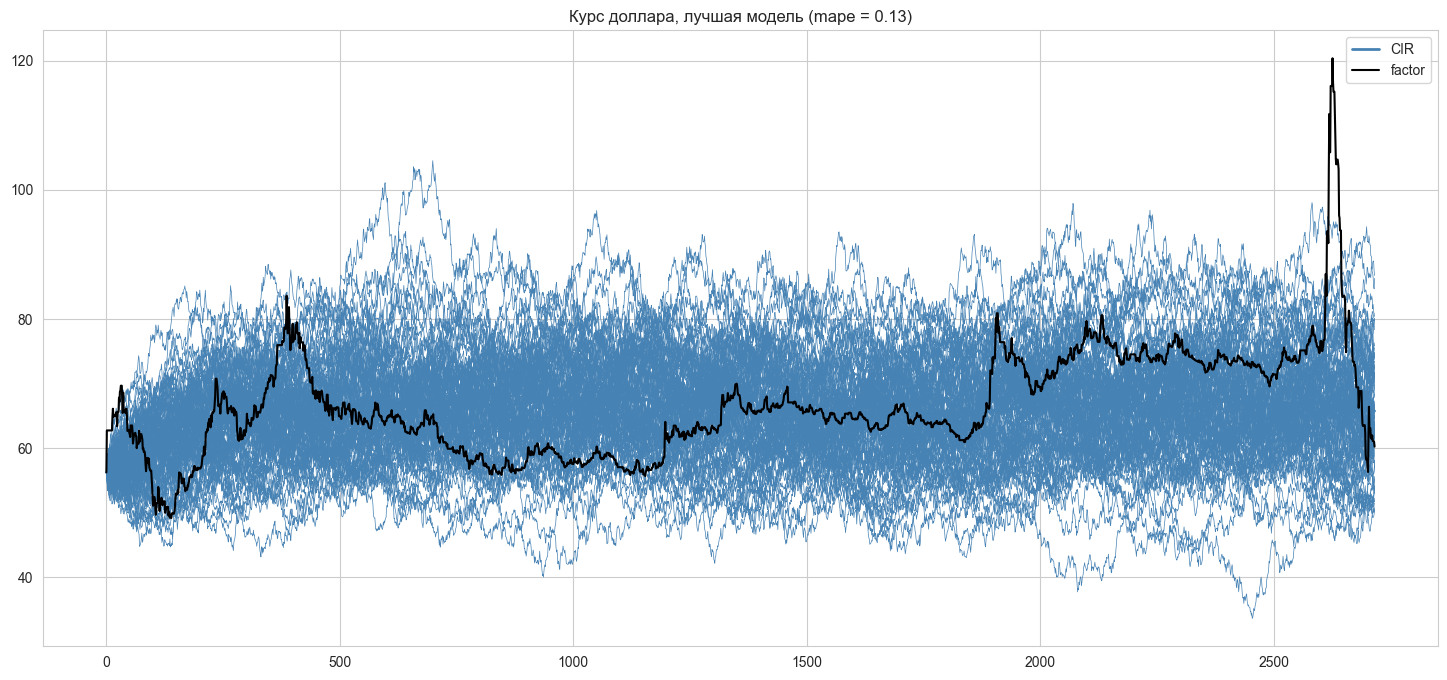

In [22]:
df_res['Курс доллара'].plot_simulations_best()

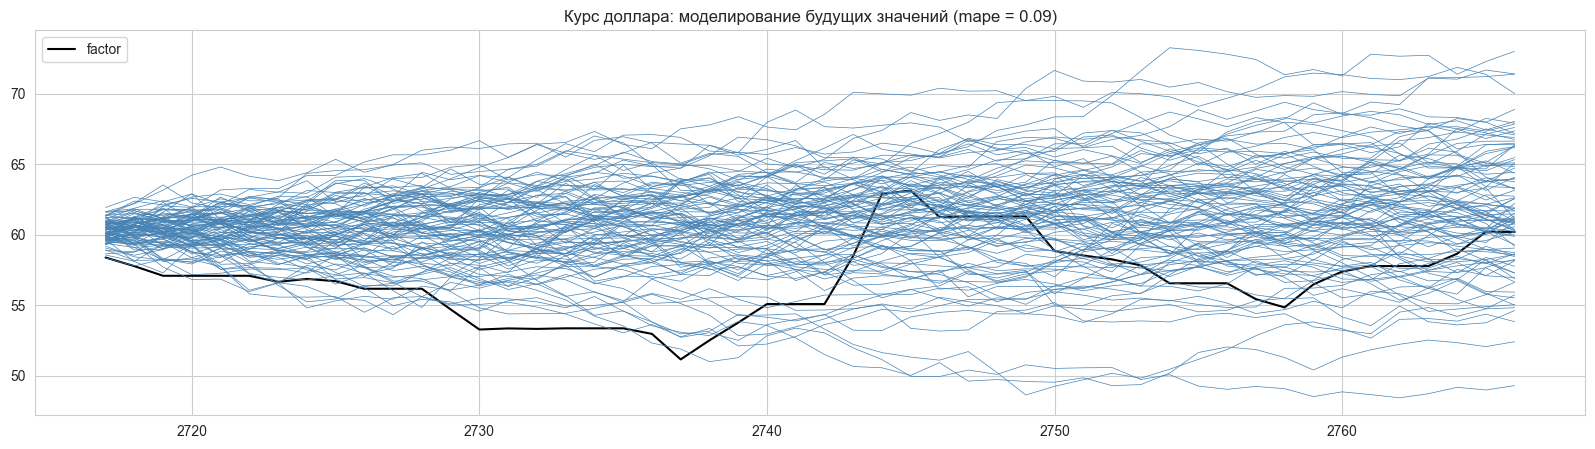

In [23]:
np.array(df_res['Курс доллара'].future_simulation(n_steps=50, plot=1));